Modify slabmesh to mesh the Sagaing fault
-------

Eric Lindsey, Apr 2025

Runs a series of commands to make a vertical triangular mesh for a portion of the Sagaing fault


In [27]:
#default python
from __future__ import division
from __future__ import absolute_import
from six.moves import range

# required
import numpy as np
from scipy.interpolate import interp1d
from scipy.interpolate import LinearNDInterpolator
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import pandas as pd
import pyproj

# for 3D plots: requires ipympl package
#from mpl_toolkits.mplot3d import Axes3D 

# needed in slabMesh - import here to check availability.
# meshpy is available from conda forge (e.g.: conda install -c conda-forge meshpy scipy netcdf4)
import meshpy.triangle as triangle
import scipy.io as scio
from netCDF4 import Dataset

# local import
import slabMesh

# set modules to reload when changed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


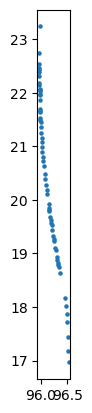

16.963872 23.240103


In [28]:
# load the surface points
fname = 'sagaing_trace.csv'

df = pd.read_csv(fname)
lon=np.array(df.lon_DD)
lat=np.array(df.lat_DD)

%matplotlib inline
# make a plot of the fault points, and print min/max of lat.
fig,ax = plt.subplots()
ax.scatter(lon,lat,5)
ax.set_aspect(1, adjustable=None)
plt.show()
print(np.min(lat),np.max(lat))


/var/folders/sk/yyr_g66j6rsdlxf5ss0mrqj40000gn/T/ipykernel_9792/560282935.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


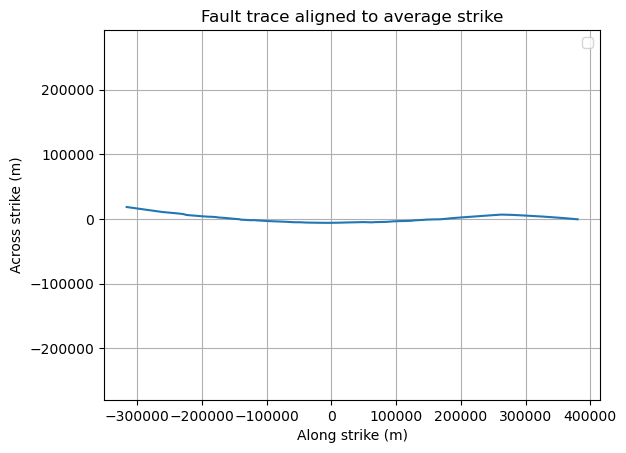

In [29]:
# project into meters and onto a best-fitting line

# Define a projection centered near the middle of the fault
center_lon = np.mean(lon)
center_lat = np.mean(lat)
proj = pyproj.Proj(proj='tmerc', lat_0=center_lat, lon_0=center_lon)

# Project lon/lat to x/y in meters
x, y = proj(lon, lat)

# Fit a line: y = m*x + b
A = np.vstack([x, np.ones_like(x)]).T
m, b = np.linalg.lstsq(A, y, rcond=None)[0]

# Strike vector (not normalized)
dx = 1
dy = m
strike_vector = np.array([dx, dy]) / np.sqrt(dx**2 + dy**2)

# Origin of the fault trace (could use first point or mean point)
x0, y0 = np.mean(x),np.mean(y)


# Vectors from origin
dxs = x - x0
dys = y - y0
vectors = np.vstack([dxs, dys])

# Dot product with unit strike vector to get along-strike distances
along_strike = strike_vector @ vectors

# Rotate strike vector 90° counterclockwise to get the normal vector
# If strike_vector = [dx, dy], then normal_vector = [-dy, dx]
normal_vector = np.array([-strike_vector[1], strike_vector[0]])

# Dot product with normal vector to get across-strike distances
across_strike = normal_vector @ vectors


fig,ax = plt.subplots()
plt.plot(along_strike, across_strike)

plt.axis('equal')  # Ensures equal aspect ratio in data units
plt.xlabel('Along strike (m)')
plt.ylabel('Across strike (m)')
plt.legend()
plt.title('Fault trace aligned to average strike')

plt.grid(True)
plt.show()



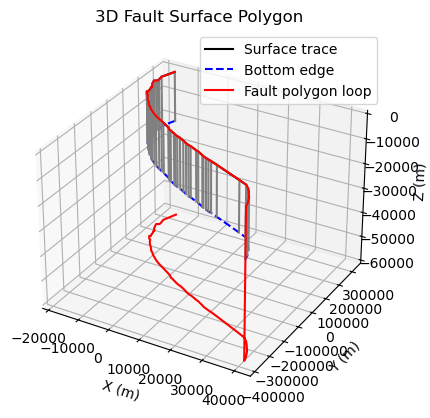

In [30]:
# next, we need to create a polygon to be filled in with the mesh, extending from the fault trace down to some depth (say 30 km). 
# Let's simply extend all the points downward and then make a loop out of them.

# Set depth (in meters)
depth = 20e3  # 30 km
stretchdepth=3;

# Surface points (z = 0)
surface_xyz = np.vstack([x, y, np.zeros_like(x)]).T

# Bottom points (z = depth), same x and y (offset to prevent vertical faults)
bottom_xyz = np.vstack([x, y+1e-3, np.full_like(x, -depth*stretchdepth)]).T

# Stack points to create a closed polygon loop
# Go along surface, then return along bottom in reverse
polygon_loop = np.vstack([surface_xyz, bottom_xyz[::-1]])

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface trace
ax.plot(x, y, np.zeros_like(x), 'k-', label='Surface trace')

# Plot the bottom trace
ax.plot(x, y, -depth * np.ones_like(x), 'b--', label='Bottom edge')

# Connect top to bottom at each trace point
for i in range(len(x)):
    ax.plot([x[i], x[i]], [y[i], y[i]], [0, -depth], 'gray')

# Optionally plot the loop
ax.plot(polygon_loop[:,0], polygon_loop[:,1], polygon_loop[:,2], 'r-', label='Fault polygon loop')


ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('3D Fault Surface Polygon')
ax.legend()
plt.show()



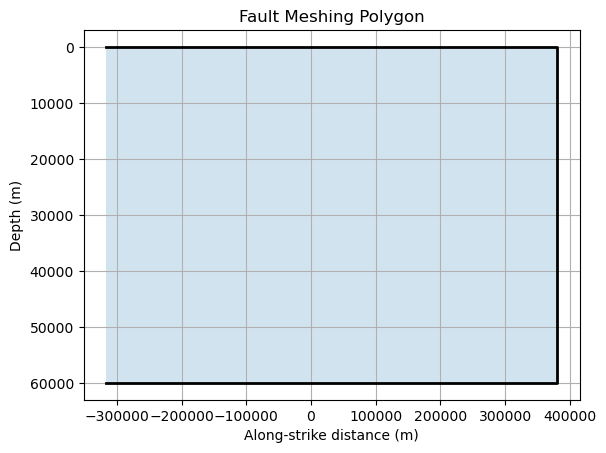

In [31]:
# Surface along-strike coordinates (depth = 0)
X_surf = along_strike
Y_surf = np.zeros_like(X_surf)

# Bottom edge (same along-strike, depth = 30 km)
X_bottom = along_strike[::-1]          # reverse for proper loop closure
Y_bottom = np.full_like(X_bottom, depth*stretchdepth)  # depth in meters

# Combine into closed polygon
Xpoly = np.array([X_surf[0],X_surf[-1], X_bottom[0],X_bottom[-1]])
Ypoly = np.array([Y_surf[0],Y_surf[-1], Y_bottom[0],Y_bottom[-1]])

plt.figure()
plt.plot(Xpoly, Ypoly, 'k-', lw=2)
plt.fill(Xpoly, Ypoly, alpha=0.2)
plt.xlabel('Along-strike distance (m)')
plt.ylabel('Depth (m)')
plt.gca().invert_yaxis()  # depth increases downward
plt.title('Fault Meshing Polygon')
plt.grid(True)
plt.show()


polygon is OK
Adjusted vertex 2 from x=380394.45061478624 to x=380394.45061578625 to avoid vertical segment.
Adjusted vertex 0 from x=-316396.4230712819 to x=-316396.4230702819 to avoid vertical segment.


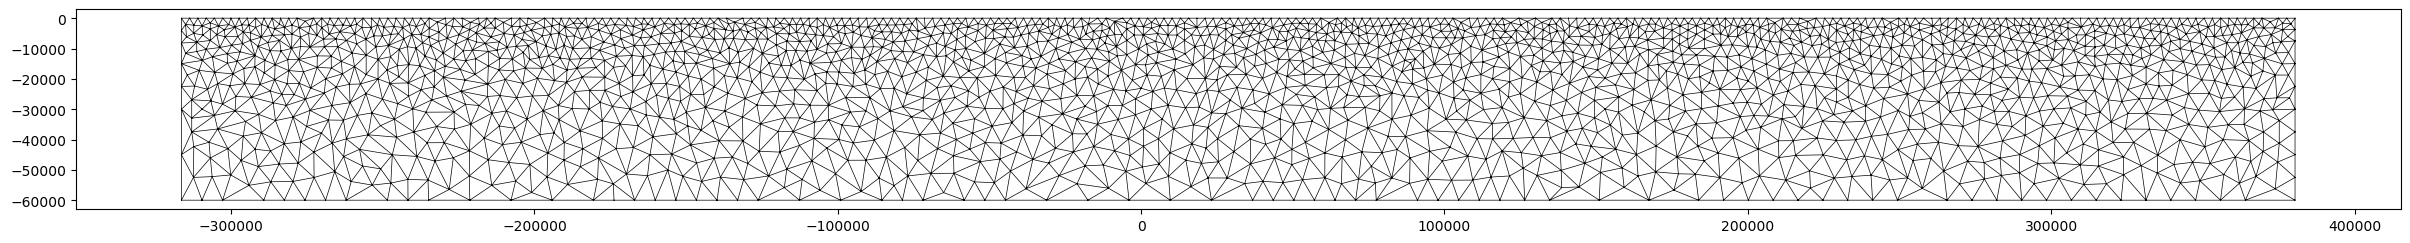

4216 triangles


In [32]:
# create the mesh based on the input polygon. 
# Edge refinement is controlled by the 'nkeep' value in the cell above.
# Interior refinement is controlled by the function needs_refinement in slabMesh.
# You may have to manually adjust the hard-coded numbers in that function. 
# See meshPy documentation for more.

# note, meshpy does not like exactly vertical lines, and randomly causes jupyter-lab to crash sometimes. If this happens,
# try changing the 'skip' value in the cell above, to skip some points along the bottom edge to make the lines non-vertical.
# you could also change some values in the refinement function of slabMesh.
# hard to understand why this happens, but also sometimes just running the whole notebook again causes it to succeed.

# Assuming Xgrid, Ygrid, Zgrid are 1D arrays (or flattened) from your slab data.
# They might come directly from slabMesh.load_slab2_grid or similar.
depth_interp = LinearNDInterpolator(list(zip(Xpoly, Ypoly)), Ypoly)

poly = Polygon(zip(Xpoly, Ypoly))
if not poly.is_valid:
    print("Warning: The polygon is invalid. Consider cleaning the input geometry.")
else:
    print('polygon is OK')

# for 510
# mesh_points,mesh_tris = slabMesh.make_depth_variable_mesh(Xpoly,Ypoly,depth_interp,threshold=3.5e7,factor=5e3,max_refinements=20000)
# for 1034: 
# mesh_points,mesh_tris = slabMesh.make_depth_variable_mesh(Xpoly,Ypoly,depth_interp,threshold=1.5e7,factor=2.46e3,max_refinements=20000)
# for 2085
# mesh_points,mesh_tris = slabMesh.make_depth_variable_mesh(Xpoly,Ypoly,depth_interp,threshold=0.88e7,factor=1.15e3,max_refinements=20000)
# for 4216
mesh_points,mesh_tris = slabMesh.make_depth_variable_mesh(Xpoly,Ypoly,depth_interp,threshold=0.38e7,factor=0.6e3,max_refinements=30000)


plt.figure(figsize=(30,30))
ax = plt.gca() 
ax.set_aspect(1)

plt.triplot(mesh_points[:, 0], -mesh_points[:, 1], mesh_tris, color='k', linewidth=0.5, antialiased=True)
#plt.plot(Xpoly,Ypoly,'rx')
plt.show()
print(len(mesh_tris),'triangles')

reversing the order of 2073 triangles for Jointinv
now there are 0 wrong triangles for Jointinv


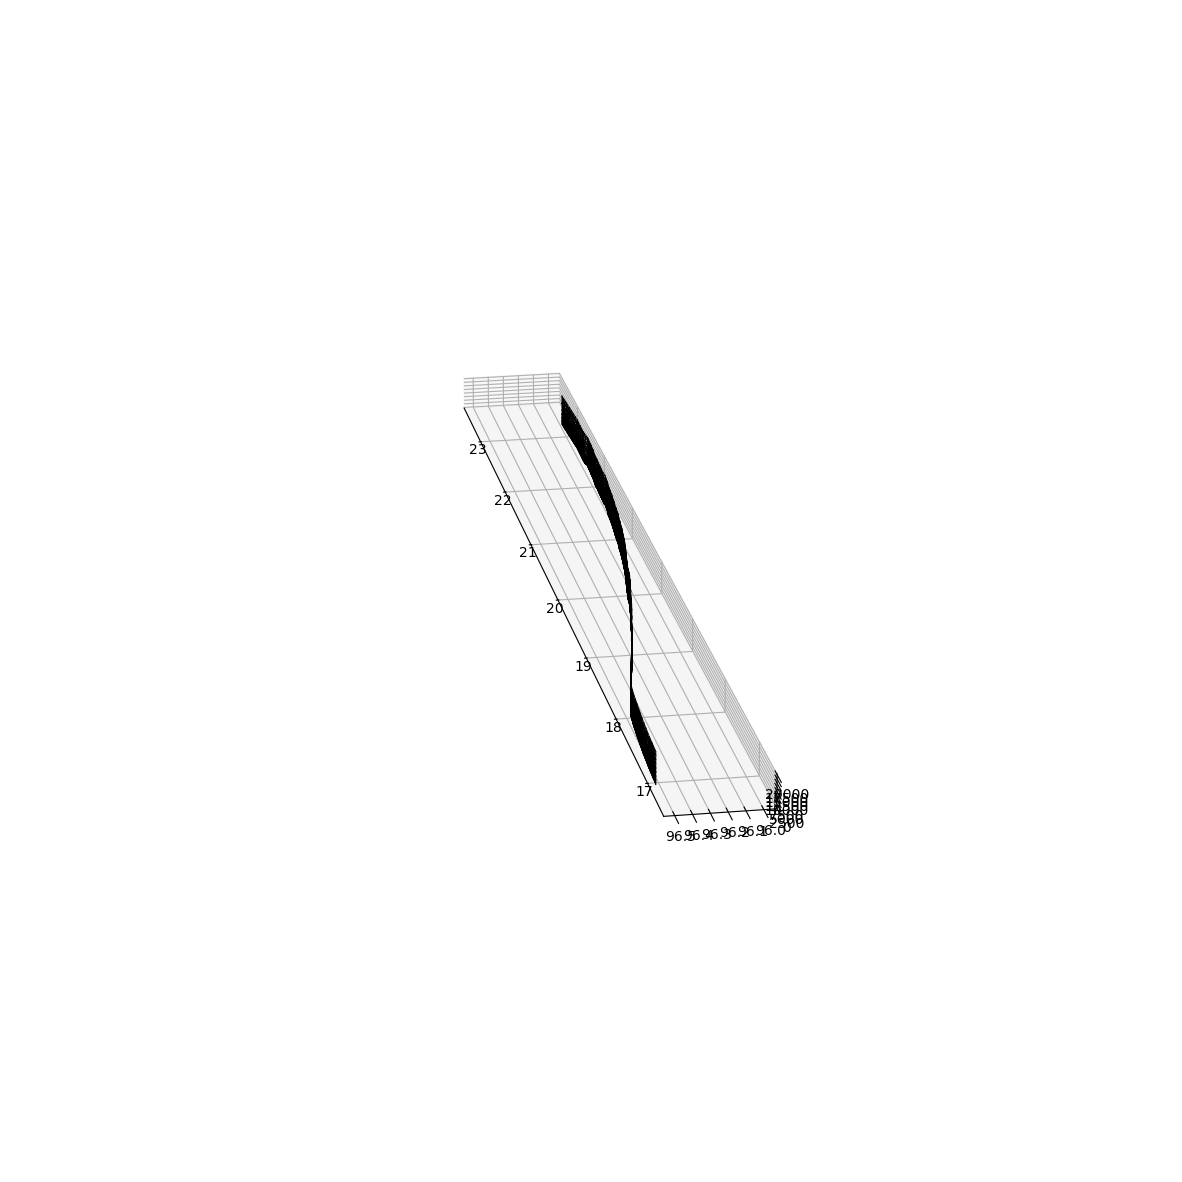

4216 triangles


In [33]:
# reproject our coordinates back to the X,Y plane (and lon,lat)

# Suppose these arrays come from your fault trace:
# along_strike: the along‑strike distances computed earlier (monotonic)
# x, y: the corresponding projected coordinates (in meters)
# Ensure they are sorted (if not already)
sort_idx = np.argsort(along_strike)
along_strike_sorted = along_strike[sort_idx]
x_sorted = lon[sort_idx]
y_sorted = lat[sort_idx]


# Build interpolation functions for x and y as a function of along_strike
interp_x = interp1d(along_strike_sorted, x_sorted, kind='linear', fill_value='extrapolate')
interp_y = interp1d(along_strike_sorted, y_sorted, kind='linear', fill_value='extrapolate')

# Now assume mesh_points is an (N, 2) array, where the first column is the along-strike coordinate
# and the second column is depth (e.g., positive downward). For example:
# mesh_points = np.array([[S0, depth0], [S1, depth1], ...])

mesh_along = mesh_points[:, 0]
mesh_depth = mesh_points[:, 1]

# Interpolate true x,y coordinates for the mesh points
mesh_true_x = interp_x(mesh_along)
mesh_true_y = interp_y(mesh_along)

# Assemble a full 3D coordinate array
# note it is lat, lon, depth for some reason...
final_points = np.column_stack([mesh_true_y, mesh_true_x, mesh_depth/stretchdepth])


# final_points is an (N, 3) array of XYZ coordinates
# mesh_tris is an (M, 3) array of indices into final_points

# Get the three points for each triangle
p1 = final_points[mesh_tris[:, 0], :]
p2 = final_points[mesh_tris[:, 1], :]
p3 = final_points[mesh_tris[:, 2], :]

# Compute the edge vectors
v1 = p2 - p1
v2 = p3 - p2

# Compute cross products for each triangle
cp = np.cross(v1, v2)

# Identify triangles with a positive z component (indicating counterclockwise order)
wrong_order = cp[:, 2] > 0

# For these triangles, swap vertices 1 and 2 to reverse the order
# Identify indices of triangles with counterclockwise ordering
wrong_idx = np.where(wrong_order)[0]

print("reversing the order of", len(wrong_idx), "triangles for Jointinv")

# Use a temporary copy to swap the 2nd and 3rd vertex indices
temp = mesh_tris[wrong_idx, 1].copy()
mesh_tris[wrong_idx, 1] = mesh_tris[wrong_idx, 2]
mesh_tris[wrong_idx, 2] = temp


# Get the three points for each triangle
p1 = final_points[mesh_tris[:, 0], :]
p2 = final_points[mesh_tris[:, 1], :]
p3 = final_points[mesh_tris[:, 2], :]

# Compute the edge vectors
v1 = p2 - p1
v2 = p3 - p2

# Compute cross products for each triangle
cp = np.cross(v1, v2)

# Identify triangles with a positive z component (indicating counterclockwise order)
wrong_order = cp[:, 2] > 0

# For these triangles, swap vertices 1 and 2 to reverse the order
# Identify indices of triangles with counterclockwise ordering
wrong_idx = np.where(wrong_order)[0]

print("now there are", len(wrong_idx), "wrong triangles for Jointinv")



# conda/jupyter installations to enable interactive plots:
#
# conda install -c conda-forge ipympl
# jupyter labextension install @jupyter-widgets/jupyterlab-manager (must run again, even if installed before)
# jupyter labextension install jupyter-matplotlib
#
#%matplotlib widget 


fig=plt.figure(figsize=(15,50))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20, azim=-190)


#ax.scatter(mesh_true_x,mesh_true_y,mesh_depth)
# Plot the mesh as a wireframe using plot_trisurf with facecolor set to 'none'
ax.plot_trisurf(final_points[:,0], final_points[:,1], final_points[:,2],
                triangles=mesh_tris, color='none', edgecolor='k', linewidth=0.5, antialiased=True, label='Mesh Wireframe')


# Calculate the extents of your data
x_range = np.ptp(final_points[:, 0])
y_range = np.ptp(final_points[:, 1])
z_range = np.ptp(final_points[:, 2])

# # Set the box aspect to the exact data ranges
# ax.set_box_aspect((x_range, y_range, z_range))
vertical_exaggeration = 111000  # roughly true vertical exaggeration

ax.set_box_aspect((x_range, y_range, z_range / vertical_exaggeration))

plt.show()
print(len(mesh_tris),'triangles')


In [34]:
len(mesh_tris)



4216

In [35]:
# save mesh to .mat file for Blocks input
fname='sagaing_dep%d_tri%d'%(depth/1e3,len(mesh_tris))

print(fname)

slabMesh.save_mesh_for_blocks(final_points,mesh_tris,fname+'.mat')
slabMesh.save_mesh_for_unicycle(final_points,mesh_tris,fname)


sagaing_dep20_tri4216


In [36]:
# max depth
np.max(final_points[:,2])



np.float64(20000.0)